### Import module

In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import string
%matplotlib inline

### Declare the hardware device to train the model

In [2]:
if torch.cuda.is_available(): 
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3090


# Setting

In [3]:
filename = "All_Full_EA_THF"
MAX_LEN = 500 #due to the max length of the token [most BERT agree 512 token] => 512 without features or labels in it
# batch size = 16, 32
batch_size = 24

### Load Data

In [4]:
df_crime = pd.read_csv('../Data/THR_DLR_CLA_V2_Primary_Full_EA_THF_Shuffle.csv')
df_crime

,News Title,News_Intro,News_Desc,News_All,Gambling,Murder,Sexual Abuse,Theft/Burglary,Drug,Battery/Assault,Accident,Non-Crime
0,นครบาลจับ 3 ผู้ต้องหาขนยาไอซ์จากอีสานเข้ากรุงล...,ตร.นครบาล จับยาเสพติดลอตใหญ่ เป็นยาไอซ์ 570 กก...,ตร.นครบาล จับยาเสพติดลอตใหญ่ เป็นยาไอซ์ 570 กก...,นครบาลจับ 3 ผู้ต้องหาขนยาไอซ์จากอีสานเข้ากรุงล...,0,0,0,0,1,0,0,0
1,ล่า'บังนัท'ลวง12ขวบขืนใจ ชี้คนใกล้ตัวไว้ใจร้าย...,เผยโฉม &quot;บังนัท&quot; หนุ่มใหญ่วัย 42 ปี ล...,จากกรณีตำรวจเร่งติดตามไล่ล่าตัว คนร้ายที่ก่อเห...,ล่า'บังนัท'ลวง12ขวบขืนใจ ชี้คนใกล้ตัวไว้ใจร้าย...,0,0,1,0,0,0,0,0
2,บช.ปส.บุกค้นโกดังต้นทางส่งออก “ยานรก” เข้าไต้ห...,ตำรวจ ปส.บุกทลายแหล่งพักยาแก๊งยาเสพติดเครือข่า...,ตำรวจ ปส.บุกทลายแหล่งพักยาแก๊งยาเสพติดเครือข่า...,บช.ปส.บุกค้นโกดังต้นทางส่งออก “ยานรก” เข้าไต้ห...,0,0,0,0,1,0,0,0
3,ยธ.สั่ง JSOC ทำรายชื่อ 7 กลุ่มนักโทษคดีสะเทือน...,รมว.ยุติธรรม สั่ง JSOC ทำวอชต์ลิสต์ 7 กลุ่มนัก...,รมว.ยุติธรรม สั่ง JSOC ทำวอชต์ลิสต์ 7 กลุ่มนัก...,ยธ.สั่ง JSOC ทำรายชื่อ 7 กลุ่มนักโทษคดีสะเทือน...,0,0,0,0,0,0,0,0
4,รวบ&quot;ป้าคำ&quot;มอมยาหนุ่มเมืองผู้ดีซิวนาฬ...,ตร.พัทยา โชว์ฝีมือตามรวบ'ป้าคำ มหาภัย'มอมยารูด...,เมื่อวันที่ 29 ม.ค. พ.ต.อ.อภิชัย กรอบเพชร ผกก....,รวบ&quot;ป้าคำ&quot;มอมยาหนุ่มเมืองผู้ดีซิวนาฬ...,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8920,ใช้มาตรการพิเศษแทนเอาผิดอาญา 'ม.3'รุมสหบาทา'ม.2',กรมพินิจฯใช้มาตรการพิเศษแทนดำเนินคดีอาญากับนัก...,เมื่อวันที่ 4 ก.พ. ที่กระทรวงยุติธรรม นายสหการ...,ใช้มาตรการพิเศษแทนเอาผิดอาญา 'ม.3'รุมสหบาทา'ม....,0,0,0,0,0,1,0,0
8921,ผอ.ปัดบีบ'ด.ญ.12ขวบ'ลาออก โร่แจ้งความเอาผิดเพจดัง,ผอ.สาวโรงเรียนสังกัดเทศบาลสระบุรี ยืนยันไม่ได้...,จากกรณีโลกออนไลน์วิพากษ์วิจารณ์อย่างดุเดือด หล...,ผอ.ปัดบีบ'ด.ญ.12ขวบ'ลาออก โร่แจ้งความเอาผิดเพจ...,0,0,1,0,0,1,0,0
8922,'ผู้กองจอย'ใจสู้ไม่เสียขวัญ ลั่นขออยู่ต่อช่วยเ...,รอง ผบช.ตชด. เยี่ยมปลอบขวัญให้กำลังใจตำรวจ ตชด...,เมื่อวันที่ 9 ม.ค. ที่ รพ.สิริรัตนรักษ์ ศูนย์ป...,'ผู้กองจอย'ใจสู้ไม่เสียขวัญ ลั่นขออยู่ต่อช่วยเ...,0,0,0,0,0,0,0,0
8923,"""คมนาคม"" แง้มข่าวดี เตรียมคลายล็อก บนขบวนรถไฟฟ...","""ศักดิ์สยาม"" เผยข่าวดี หลังกรมรางฯมีข้อมูลนักร...","""ศักดิ์สยาม"" เผยข่าวดี หลังกรมรางฯมีข้อมูลนักร...","""คมนาคม"" แง้มข่าวดี เตรียมคลายล็อก บนขบวนรถไฟฟ...",0,0,0,0,0,0,0,1


### Preprocessing Data

In [5]:
encoding = {
    'Grambling': [1, 0, 0, 0, 0, 0, 0, 0, 0],
    'Murder': [0, 1, 0, 0, 0, 0, 0, 0, 0],
    'Sexual Abuse': [0, 0, 1, 0, 0, 0, 0, 0, 0],
    'Theft/Burglary': [0, 0, 0, 1, 0, 0, 0, 0, 0],
    'Drug': [0, 0, 0, 0, 1, 0, 0, 0, 0],
    'Battery/Assault': [0, 0, 0, 0, 0, 1, 0, 0, 0],
    'Accident': [0, 0, 0, 0, 0, 0, 1, 0, 0],
    'Crime/Violence-Other': [0, 0, 0, 0, 0, 0, 0, 1, 0],

}
# encoding = {
#     'Grambling': [1, 0, 0, 0, 0, 0, 0, 0, 0],
#     'Murder': [0, 1, 0, 0, 0, 0, 0, 0, 0],
#     'Sexual Abuse': [0, 0, 1, 0, 0, 0, 0, 0, 0],
#     'Theft/Burglary': [0, 0, 0, 1, 0, 0, 0, 0, 0],
#     'Drug': [0, 0, 0, 0, 1, 0, 0, 0, 0],
#     'Battery/Assault': [0, 0, 0, 0, 0, 1, 0, 0, 0],
#     'Accident': [0, 0, 0, 0, 0, 0, 1, 0, 0],
#     'Crime/Violence-Other': [0, 0, 0, 0, 0, 0, 0, 1, 0],
#     'Non-Crime': [0, 0, 0, 0, 0, 0, 0, 0, 1]
# }
type(encoding)

dict

In [6]:
def clean_msg(msg):
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    msg = re.sub(r'<.*?>','', msg)
    # ลบ hashtag
    msg = re.sub(r'#','',msg)
    # ลบ space
    msg = re.sub(r' ','',msg)
    # ลบ เครื่องหมายคำพูด (punctuation)
    for c in string.punctuation:
        msg = re.sub(r'\{}'.format(c),'',msg)
    # ลบ separator เช่น \n \t
    msg = ' '.join(msg.split())
    return msg

#### Extract New_Data and News_Label

In [7]:
# 0:1 = title, 1:2 = Intro, 2:3 = Desc, 3:4 = All
X = df_crime.iloc[:,3:4].values 
y = df_crime.iloc[:, 4:].values

In [8]:

clean_text_arr = []
for i in range(len(X)):
    clean_text = clean_msg(X[i][0])
    temp_arr = []
    temp_arr.append(clean_text)
    clean_text_arr.append(temp_arr)
# print(clean_text_arr)
X = np.array(clean_text_arr)
print(X)
print(y)
print(X.shape)
print(y.shape)
print(type(X))

[['นครบาลจับ3ผู้ต้องหาขนยาไอซ์จากอีสานเข้ากรุงลอตใหญ่ยึดได้รวม570กกตรนครบาลจับยาเสพติดลอตใหญ่เป็นยาไอซ์570กกได้ผู้ต้องหา3รายขนยาใส่รถกระบะมาจากชายแดนภาคอีสานส่งให้ลูกค้าในพื้นที่ภาคกลางผบตรเชื่อจากนี้งานหนักเพราะยาเสพติดอั้นมาจากช่วงโควิดเมื่อเวลา0900นวันที่19มิยพลตอจักรทิพย์ชัยจินดาผบตรเป็นประธานประชุมเพื่อกำหนดมาตรการป้องกันการลักลอบขนส่งยาเสพติดทางไปรษณีย์พัสดุภัณฑ์และระบบขนส่งที่ห้องประชุมศรียานนท์ชั้น2สำนักงานตำรวจแห่งชาติพลตอจักรทิพย์กล่าวว่าจากนี้จะต้องมีการวิเคตรนครบาลจับยาเสพติดลอตใหญ่เป็นยาไอซ์570กกได้ผู้ต้องหา3รายขนยาใส่รถกระบะมาจากชายแดนภาคอีสานส่งให้ลูกค้าในพื้นที่ภาคกลางผบตรเชื่อจากนี้งานหนักเพราะยาเสพติดอั้นมาจากช่วงโควิดเมื่อเวลา0900นวันที่19มิยพลตอจักรทิพย์ชัยจินดาผบตรเป็นประธานประชุมเพื่อกำหนดมาตรการป้องกันการลักลอบขนส่งยาเสพติดทางไปรษณีย์พัสดุภัณฑ์และระบบขนส่งที่ห้องประชุมศรียานนท์ชั้น2สำนักงานตำรวจแห่งชาติพลตอจักรทิพย์กล่าวว่าจากนี้จะต้องมีการวิเคราะห์กลุ่มผู้ค้ายาเสพติดว่าจะมียุทธศาสตร์ไปทางไหนแต่แนวโน้มในปัจจุบันพบว่ามีการส่งของทางไปรษณีย์ซึ่งไม่ใช่ว่าจะมีเพียงยาเ

#### Create new temp data? <It looks like he convert the data again>

In [9]:
X_2d = np.array([text for text in X])

# print(X_2d)
print(type(X_2d))

<class 'numpy.ndarray'>


#### Split data into train,test,val

In [10]:
from skmultilearn.model_selection import iterative_train_test_split

np.random.seed(42)
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.2)
# X_train, y_train, X_test, y_test = iterative_train_test_split(X_2d, y, test_size=0.2)
X_train, y_train, X_val, y_val = iterative_train_test_split(X_train, y_train, test_size=0.25)

#### Show the combination of label in the dataset

In [11]:
from collections import Counter
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

# order = how many possible combination of labels that want to compare
# order has been set as 3 since there might be only 3 labels in the same news <the news with highest amount of news>
# we use y_data since y is the predicted label <The one that we want to predict>
df_count = pd.DataFrame({
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(y_train, order=8) for combination in row),
    'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_test, order=8) for combination in row),
    'val' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_val, order=8) for combination in row)
}).fillna(0.0)

In [12]:
df_count

,train,test,val
"(7, 7, 7, 7, 7, 7, 7, 7)",844.0,281.0,281.0
"(1, 1, 1, 1, 1, 1, 1, 1)",1533.0,511.0,511.0
"(3, 3, 3, 3, 3, 3, 3, 3)",681.0,227.0,227.0
"(5, 5, 5, 5, 5, 5, 5, 5)",1133.0,378.0,377.0
"(1, 4, 4, 4, 4, 4, 4, 4)",97.0,32.0,32.0
...,...,...,...
"(3, 3, 3, 3, 5, 5, 5, 7)",0.0,0.0,1.0
"(3, 3, 5, 5, 5, 7, 7, 7)",0.0,0.0,1.0
"(3, 3, 3, 3, 3, 3, 5, 7)",0.0,0.0,1.0
"(3, 3, 3, 3, 5, 5, 7, 7)",0.0,0.0,1.0


#### Convert dataset into list

In [13]:
# run first loop then run second one <text is the output of those loop>
X_train_new = np.array([text for sub in X_train for text in sub]) 
X_test_new = np.array([text for sub in X_test for text in sub]) 
X_val_new = np.array([text for sub in X_val for text in sub]) 
# print(X_train_new)
# print(X_test_new)

X_train_list = X_train_new.tolist()
X_test_list = X_test_new.tolist()
X_val_list = X_val_new.tolist()
# print(X_train_list)

#### Preprocessing for BERT to tokenize the senntence

In [14]:
# !pip install sentencepiece
from transformers import AutoTokenizer, AutoModelForMaskedLM, CamembertTokenizer
# cstorm125/wangchanberta-base-att-spm-uncased-finetune
# airesearch/wangchanberta-base-att-spm-uncased
tokenizer = CamembertTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")

def preprocessing_for_bert(data):

    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            #text=text_preprocessing(sent),  
            text=sent,
            add_special_tokens=True,        
            max_length=MAX_LEN,
            truncation=True,             
            padding='max_length',         
            #return_tensors='pt',           
            return_attention_mask=True      
        )
        
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

#### Combine the numpy together

In [15]:
all_texts = np.concatenate([X_train_list, X_test_list, X_val_list])

#### Encode the text(or sentence)

In [16]:
encoded_texts = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_texts]

In [17]:
print(len(encoded_texts))

8925


In [18]:
# print(encoded_texts)

#### Check the max len of encoded text to declare the max len (for creating size of list)

In [19]:
max_len = max([len(sent) for sent in encoded_texts])
print('Max length: ', max_len)
avg_len = sum([len(sent) for sent in encoded_texts]) / len(encoded_texts)
print('Avg length: ', avg_len)

Max length:  3508
Avg length:  452.13221288515405


#### Compare the original sentence and the encoded one(or tokens)

In [20]:
token_ids = list(preprocessing_for_bert([X_train_new[0]])[0].squeeze().numpy())
print('Original: ', X_train_new[0])
print('\n')
print('Tokenized: ', tokenizer.tokenize(X_train_new[0]))
print('\n')
print('Token IDs: ', token_ids)

print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train_new)
val_inputs, val_masks = preprocessing_for_bert(X_val_new)

Original:  ยธสั่งJSOCทำรายชื่อ7กลุ่มนักโทษคดีสะเทือนขวัญต้องจับตาหากปล่อยตัวรมวยุติธรรมสั่งJSOCทำวอชต์ลิสต์7กลุ่มนักโทษสะเทือนขวัญให้ปชชเชื่อมั่นในมาตรฐานเผยเตรียมเชิญนายกฯร่วมสัมมนาปัญหายาเสพติด27พยชี้นายกฯให้ความสำคัญต้องเร่งทำให้สังคมปลอดภัยเมื่อวันที่11พย63ที่กระทรวงยุติธรรมนายสมศักดิ์เทพสุทินรัฐมนตรีว่าการกระทรวงยุติธรรมเป็นประธานการประชุมผู้บริหารกระทรวงยุติธรรมโดยมีศาสตราจารย์พิเศษวิศิษฏ์วิศิษฏ์สรอรรถปลัดกระทรวงยุติธรรมว่าที่รตธนกฤตจิตอารีย์รัตน์เลขานุการรมวยุติธรรมนายธนวัชรรมวยุติธรรมสั่งJSOCทำวอชต์ลิสต์7กลุ่มนักโทษสะเทือนขวัญให้ปชชเชื่อมั่นในมาตรฐานเผยเตรียมเชิญนายกฯร่วมสัมมนาปัญหายาเสพติด27พยชี้นายกฯให้ความสำคัญต้องเร่งทำให้สังคมปลอดภัยเมื่อวันที่11พย63ที่กระทรวงยุติธรรมนายสมศักดิ์เทพสุทินรัฐมนตรีว่าการกระทรวงยุติธรรมเป็นประธานการประชุมผู้บริหารกระทรวงยุติธรรมโดยมีศาสตราจารย์พิเศษวิศิษฏ์วิศิษฏ์สรอรรถปลัดกระทรวงยุติธรรมว่าที่รตธนกฤตจิตอารีย์รัตน์เลขานุการรมวยุติธรรมนายธนวัชรนิติกาญจนาที่ปรึกษารมวยุติธรรมนายสามารถเจนชัยจิตวานิชผู้ช่วยรมวยุติธรรมอธิบดีทุกกรมในกระทรวงยุติธรรมและข

#### Prepare dataset for training

In [21]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_labels = torch.FloatTensor(y_train)
val_labels = torch.FloatTensor(y_val)


train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [22]:
print(y_val.shape)

(1785, 8)


In [23]:
print(y_train.shape)

(5355, 8)


In [24]:
print(next(iter(train_dataloader)))
print('length: ',len(train_dataloader))

[tensor([[    5,    10,  7361,  ...,     1,     1,     1],
        [    5,    10,  2805,  ...,     1,     1,     1],
        [    5,    10,  4348,  ...,     1,     1,     1],
        ...,
        [    5,  9676,  4664,  ...,     1,     1,     1],
        [    5,    10,    47,  ...,     1,     1,     1],
        [    5, 12303, 15925,  ...,   193,    51,     6]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), tensor([[0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 1., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.

#### Initialize BERT model

In [25]:
import torch
import torch.nn as nn
from transformers import CamembertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import CamembertConfig


def initialize_model(epochs=10):
#     configuration = CamembertConfig(max_position_embeddings=4096)
#     bert_classifier = CamembertForSequenceClassification(configuration)
    bert_classifier = CamembertForSequenceClassification.from_pretrained('airesearch/wangchanberta-base-att-spm-uncased', num_labels=8, output_attentions=False, output_hidden_states=False)
#     bert_classifier = CamembertForSequenceClassification.from_pretrained('airesearch/wangchanberta-base-att-spm-uncased', num_labels=9, output_attentions=False, output_hidden_states=False)
#     bert_classifier.config = configuration
#     print(bert_classifier.config)
    bert_classifier = nn.DataParallel(bert_classifier)
    bert_classifier.to(device)
    
    
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=2e-5,    
                      betas=(0.9, 0.98), 
                      eps=1e-6,
                      weight_decay=0.1    
                )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps
                )
    
    return bert_classifier, optimizer, scheduler

#### Train, Evaluate Code

In [26]:
import random
import time

# Specify loss function
loss_fn = nn.BCELoss()
m = nn.Sigmoid()
training_stats = list()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=10, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            outputs = model(b_input_ids, b_attn_mask)
            logits = outputs.logits

            # Compute loss and accumulate the loss values
            loss = loss_fn(m(logits), b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)

            training_stats.append(
                {
                    'Epoch': epoch_i + 1,
                    'Training_Loss': avg_train_loss,
                    'Valid_Loss': val_loss,
                    'Valid_Accuracy': val_accuracy,
                    'Time_Elapsed': time_elapsed,
                }
            )

            torch.save(model.state_dict(), f'./Model/WangChanBERTa_{filename}_epoch{epoch_i+1}.h5')
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            outputs = model(b_input_ids, b_attn_mask)
            logits = outputs.logits

        # Compute loss
        #print(logits)
        #print(b_labels)
        loss = loss_fn(m(logits), b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        # preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        # accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        accuracy = accuracy_thresh(logits.view(-1, 8), b_labels.view(-1, 8))
#         accuracy = accuracy_thresh(logits.view(-1, 9), b_labels.view(-1, 9))
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

def accuracy_thresh(y_pred, y_true, thresh:float=0.5, sigmoid:bool=True):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: 
        y_pred = y_pred.sigmoid()
    return ((y_pred > thresh) == y_true.byte()).float().mean().item()

In [27]:
print(train_dataloader)

### Train the model

In [28]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=100)
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wa

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.450390   |     -      |     -     |   8.33   
   1    |   40    |   0.385164   |     -      |     -     |   7.96   
   1    |   60    |   0.381446   |     -      |     -     |   7.98   
   1    |   80    |   0.361010   |     -      |     -     |   8.02   
   1    |   100   |   0.351549   |     -      |     -     |   8.19   
   1    |   120   |   0.339384   |     -      |     -     |   8.20   
   1    |   140   |   0.348637   |     -      |     -     |   8.22   
   1    |   160   |   0.335260   |     -      |     -     |   8.21   
   1    |   180   |   0.334912   |     -      |     -     |   8.24   
   1    |   200   |   0.299109   |     -      |     -     |   8.24   
   1    |   220   |   0.286225   |     -      |     -     |   8.26   
   1    |   223   |   0.294359   |     -      |     -     |   0.90   


#### Evaluate the model

In [29]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            outputs = model(b_input_ids, b_attn_mask)
            logits = outputs.logits
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = all_logits.sigmoid().cpu().numpy()

    return probs

In [30]:
print(training_stats)

[{'Epoch': 1, 'Training_Loss': 0.3517641451741968, 'Valid_Loss': 0.2912376795212428, 'Valid_Accuracy': 0.893263905843099, 'Time_Elapsed': 100.9516830444336}, {'Epoch': 2, 'Training_Loss': 0.21812907825889333, 'Valid_Loss': 0.20786195983489356, 'Valid_Accuracy': 0.9248379818598429, 'Time_Elapsed': 100.39083337783813}, {'Epoch': 3, 'Training_Loss': 0.17108264568793988, 'Valid_Loss': 0.15080927163362504, 'Valid_Accuracy': 0.9435648330052694, 'Time_Elapsed': 101.00534582138062}, {'Epoch': 4, 'Training_Loss': 0.1424830593833966, 'Valid_Loss': 0.16535163164138794, 'Valid_Accuracy': 0.9375231695175171, 'Time_Elapsed': 101.22222137451172}]


#### Show the val_accuracy based on each epoch

In [31]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('Epoch')

# Display the table.
df_stats.sort_values(by=['Valid_Accuracy'], ascending=False)

,Training_Loss,Valid_Loss,Valid_Accuracy,Time_Elapsed
Epoch,,,,
3,0.171083,0.150809,0.943565,101.005346
4,0.142483,0.165352,0.937523,101.222221
2,0.218129,0.207862,0.924838,100.390833
1,0.351764,0.291238,0.893264,100.951683


#### Training & Validation Loss Graph

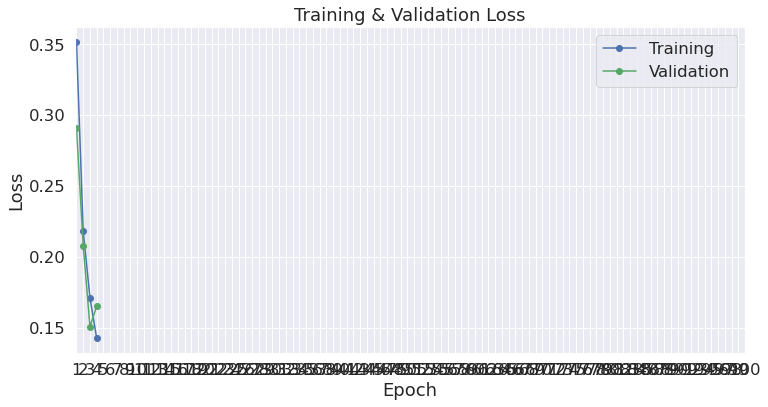

In [32]:
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training_Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid_Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
num_list = []
for i in range(100):
    num_list.append(i+1)
plt.xticks(num_list)

plt.show()

#### BERT Predict

In [33]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test_new)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

Tokenizing data...


In [34]:
probs = bert_predict(bert_classifier, test_dataloader)

In [35]:
print(probs)
print(np.round(probs))
print(len(probs[0]))

[[0.01102471 0.0141535  0.0121949  ... 0.02869009 0.02326615 0.0328374 ]
 [0.014745   0.04535591 0.9752187  ... 0.26068667 0.02317286 0.0198648 ]
 [0.03199362 0.05379619 0.00720043 ... 0.3337497  0.01259213 0.00685272]
 ...
 [0.00294983 0.00660551 0.00894551 ... 0.03204894 0.01256222 0.1325317 ]
 [0.00322603 0.00805716 0.00373751 ... 0.03232958 0.01413006 0.41566956]
 [0.00996243 0.8213953  0.01745312 ... 0.21068938 0.09079155 0.00514854]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
8


In [36]:
# Hey_DataFrame = pd.DataFrame(probs, columns= ['A','B','C','D','E','F','G','H'])
# Hey_DataFrame['A'][Hey_DataFrame['A'] > 0.0005] = 1
# Hey_DataFrame

#### Replace new prob data into the file

In [37]:
import pickle
with open(f'./pickle_files/probs_{filename}.pkl', 'wb') as prob:
    pickle.dump(probs, prob)
with open(f'./pickle_files/Y_Test_{filename}.pkl','wb') as result:
    pickle.dump(y_test, result)

In [38]:
print(y_test)

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [39]:
len(y_test[0])

8

In [40]:
len(probs[0])

8

In [41]:
from sklearn.metrics import classification_report

# start from 5 since we need to avoid the news_data <Topic,Intro,Desc,All>
df_label_columns = df_crime.columns[4:]
label_names = list(df_label_columns)

print(classification_report(y_test, np.round(probs), target_names=label_names, zero_division=0))
df_label_columns

                 precision    recall  f1-score   support

       Gambling       0.71      0.80      0.75        50
         Murder       0.85      0.83      0.84       511
   Sexual Abuse       0.87      0.88      0.87       135
 Theft/Burglary       0.92      0.55      0.69       227
           Drug       0.86      0.87      0.86       208
Battery/Assault       0.71      0.47      0.57       378
       Accident       0.72      0.76      0.74       144
      Non-Crime       0.82      0.75      0.78       281

      micro avg       0.82      0.72      0.76      1934
      macro avg       0.81      0.74      0.76      1934
   weighted avg       0.82      0.72      0.76      1934
    samples avg       0.70      0.66      0.67      1934



Index(['Gambling', 'Murder', 'Sexual Abuse', 'Theft/Burglary', 'Drug',
       'Battery/Assault', 'Accident', 'Non-Crime'],
      dtype='object')

#### Hamming Loss

In [42]:
# Hamming loss is the fraction of labels that are incorrectly predicted
from sklearn.metrics import hamming_loss

print(f"Hamming Loss: {hamming_loss(y_test, np.round(probs))}")

Hamming Loss: 0.0600140056022409


#### ROC Curve

In [43]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and ROC area for each class
n_classes = len(df_crime.columns[5:])
print(n_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], probs[:, i])

df_crime.columns[5:]

7


Index(['Murder', 'Sexual Abuse', 'Theft/Burglary', 'Drug', 'Battery/Assault',
       'Accident', 'Non-Crime'],
      dtype='object')

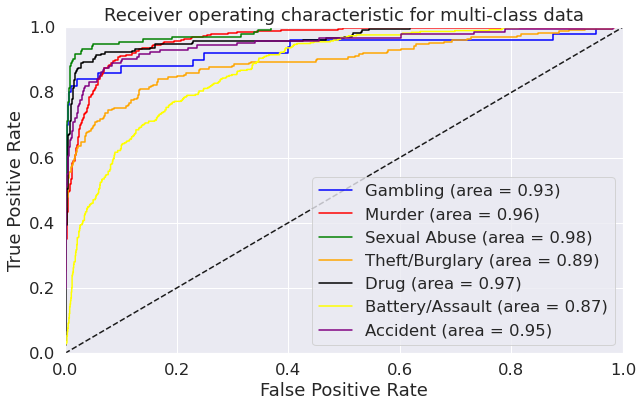

In [44]:
from itertools import cycle

news_label = ['Gambling', 'Murder', 'Sexual Abuse', 'Theft/Burglary', 'Drug', 'Battery/Assault', 'Accident', 'Non-Crime']
colors = cycle(['blue', 'red', 'green', 'orange', 'black', 'yellow', 'purple', 'pink', 'grey'])
plt.figure(figsize=(10,6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linewidth=1.5, label=f'{news_label[i]} (area = {roc_auc[i]:.2f})')
#     plt.plot(fpr[i], tpr[i], color=color, linewidth=1.5, label=f'ROC curve of class {news_label[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

#### Precision Recall Curve

In [45]:
from sklearn.metrics import precision_recall_curve, f1_score, auc

# Compute ROC curve and ROC area for each class
n_classes = len(df_crime.columns[5:])
y_pred = np.round(probs)
precision = dict()
recall = dict()
f1 = dict()
bert_auc = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], probs[:, i])
    f1[i], bert_auc[i] = f1_score(y_test[:, i], y_pred[:, i]), auc(recall[i], precision[i])

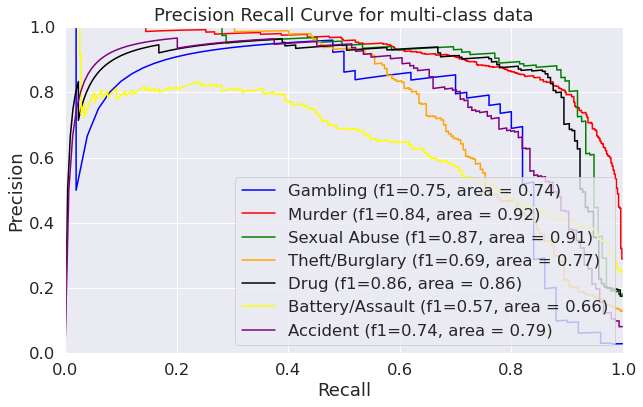

In [46]:
from itertools import cycle

news_label = ['Gambling', 'Murder', 'Sexual Abuse', 'Theft/Burglary', 'Drug', 'Battery/Assault', 'Accident', 'Non-Crime']
colors = cycle(['blue', 'red', 'green', 'orange', 'black', 'yellow', 'purple', 'pink', 'grey'])
plt.figure(figsize=(10,6))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, linewidth=1.5, label=f'{news_label[i]} (f1={f1[i]:.2f}, area = {bert_auc[i]:.2f})')
#plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [47]:
from sklearn.metrics import multilabel_confusion_matrix
Confusion_Matrix_Result = multilabel_confusion_matrix(y_test,np.round(probs))

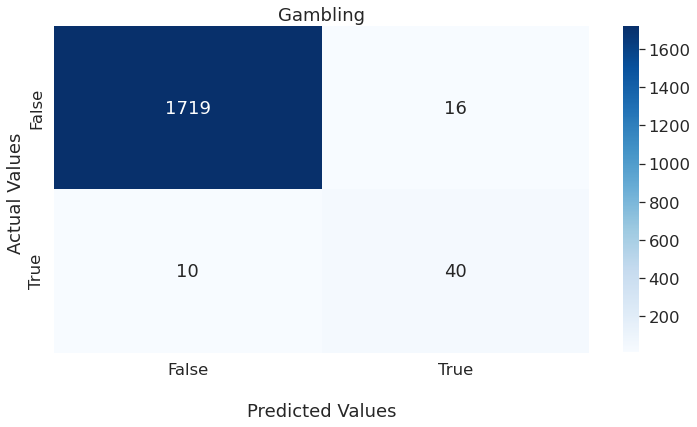

In [48]:
import seaborn as sns

ax = sns.heatmap(Confusion_Matrix_Result[0], annot=True, cmap='Blues',fmt='g')

ax.set_title(news_label[0]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

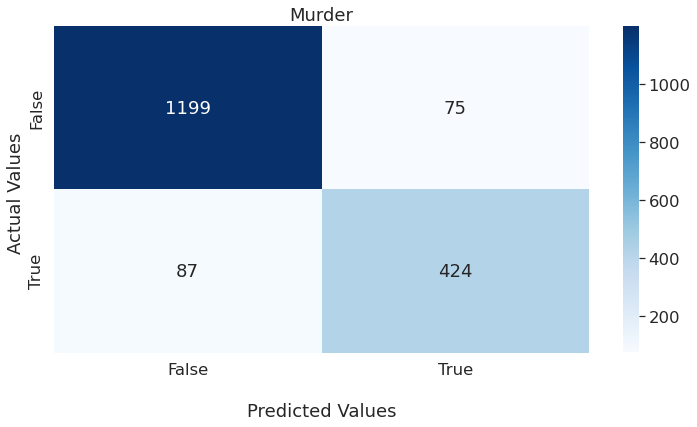

In [49]:
ax = sns.heatmap(Confusion_Matrix_Result[1], annot=True, cmap='Blues',fmt='g')

ax.set_title(news_label[1]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

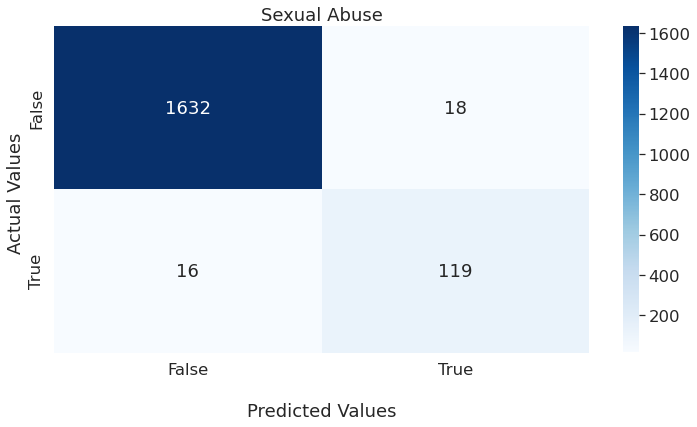

In [50]:
ax = sns.heatmap(Confusion_Matrix_Result[2], annot=True, cmap='Blues',fmt='g')

ax.set_title(news_label[2]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

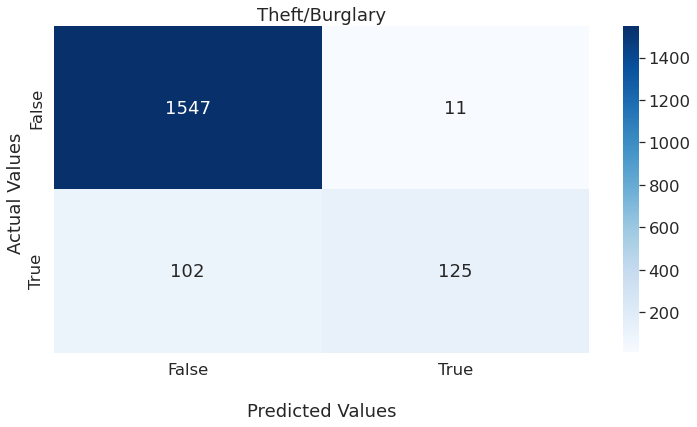

In [51]:
ax = sns.heatmap(Confusion_Matrix_Result[3], annot=True, cmap='Blues',fmt='g')

ax.set_title(news_label[3]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

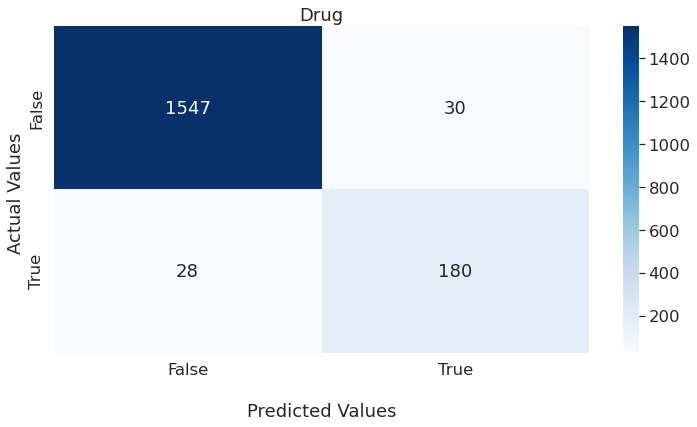

In [52]:
ax = sns.heatmap(Confusion_Matrix_Result[4], annot=True, cmap='Blues',fmt='g')

ax.set_title(news_label[4]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

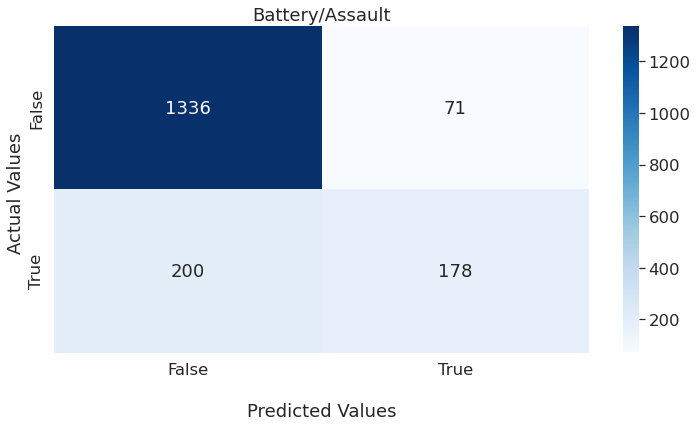

In [53]:
ax = sns.heatmap(Confusion_Matrix_Result[5], annot=True, cmap='Blues',fmt='g')

ax.set_title(news_label[5]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

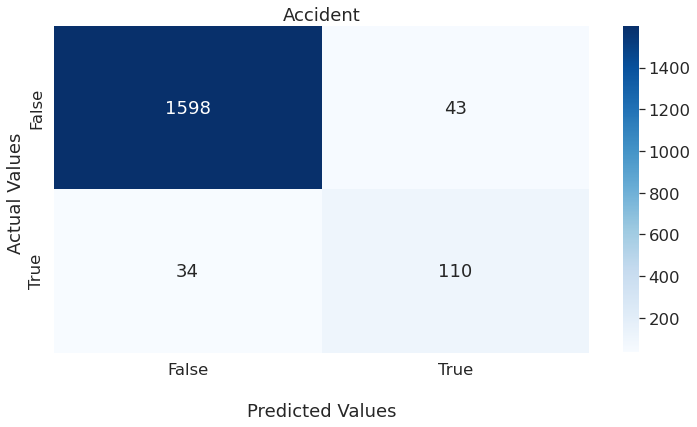

In [54]:
ax = sns.heatmap(Confusion_Matrix_Result[6], annot=True, cmap='Blues',fmt='g')

ax.set_title(news_label[6]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

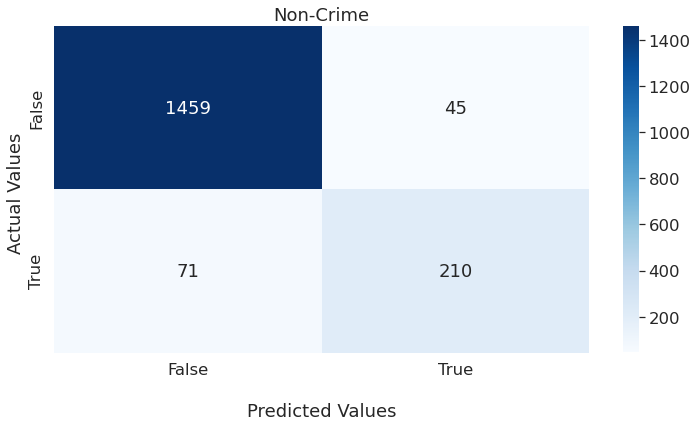

In [55]:
ax = sns.heatmap(Confusion_Matrix_Result[7], annot=True, cmap='Blues',fmt='g')

ax.set_title(news_label[7]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [56]:
bert_classifier_load = CamembertForSequenceClassification.from_pretrained('airesearch/wangchanberta-base-att-spm-uncased', num_labels=8, output_attentions=False, output_hidden_states=False)
bert_classifier_load = nn.DataParallel(bert_classifier)
bert_classifier_load.load_state_dict(torch.load('Crimson2021/Senior Project/Chosen Model/Fine_Tuning_THR_DLR_Title_500Tokens_epoch12.h5'))
bert_classifier_load.to(device)
bert_classifier_load.eval()

# Then call bert predict
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            outputs = model(b_input_ids, b_attn_mask)
            logits = outputs.logits
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = all_logits.sigmoid().cpu().numpy()

    return probs

Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wa

FileNotFoundError: [Errno 2] No such file or directory: 'Crimson2021/Senior Project/Chosen Model/Fine_Tuning_THR_DLR_Title_500Tokens_epoch12.h5'